# Predicting NMR Spectra on a Quantum Computer

This tutorial demonstrates how to simulate liquid‑state 1H NMR spectra of molecules using Qiskit. We map an N‑spin NMR Hamiltonian to qubit operators, perform Trotterized time evolution, evaluate total transverse magnetization with Estimator primitives, and recover the frequency‑domain spectrum via a Fourier transform. As an illustrative example, the figures below show cis‑3‑chloroacrylic acid.

<div style="display:flex; gap:12px; align-items:flex-start;">
  <img src="files/images/bmse000368.png" alt="Example molecule (structural formula)" style="height:260px; width:auto; object-fit:contain;">
  <img src="files/images/bmse000368_s.png" alt="Example molecule (skeletal drawing)" style="height:260px; width:auto; object-fit:contain;">
</div>

Example system: cis‑3‑chloroacrylic acid has three hydrogens ($C_3H_3ClO_2$). The acidic OH proton typically exchanges with D2O and is not observed, leaving two vinylic protons on the C=C bond that generate two distinct 1H NMR signals split by their mutual J coupling. We treat the observed protons as an N‑spin network and keep the workflow general so you can substitute any molecule with N observed 1H spins.

What this notebook does
1. Loads an N‑spin NMR Hamiltonian (struqture format), selectable by molecule.
2. Applies a rotating‑frame shift by subtracting the mean Zeeman term to improve Trotter stability.
3. Converts the N‑spin Hamiltonian to Qiskit’s SparsePauliOp (with explicit note on endianness).
4. Constructs first‑order (and optionally higher‑order) Trotter circuits for N‑spin time evolution.
5. Prepares the initial X‑basis product states and the transverse magnetization observables.
6. Uses Estimator V2 (Qiskit 2.2.x) with a statevector backend to obtain expectation values.
7. Computes the spectrum from time‑domain signals via a Fourier transform.

Where to find more information
- HQS Spectrum Tools: background and derivation of the 1D NMR spectrum
  https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/index.html
- A. Khedri et al., The impact of noise on the simulation of NMR spectroscopy on NISQ devices, arXiv:2404.18903 (2024)
  https://arxiv.org/abs/2404.18903
- Many more molecules are available in the HQS NMR Parameters database (HQS Spectrum Tools):
  https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/molecular_data.html


## Installation with conda and uv (run in a terminal before using this notebook)

To use this notebook, first create and activate a **conda environment** and install
the required packages with `uv` **from a terminal**, _not_ inside the notebook.

#### A. Create and activate a conda environment

In a terminal, run:

```bash
# Create a new conda environment (choose a name you like)
conda create -n iqm-env python=3.12

# Activate the environment
conda activate iqm-env
``` 

#### B. Install uv and the required packages into this conda environment

With the environment activated, install uv first:


```bash
pip install uv
``` 

Then install the required packages with uv into this environment:

```bash
uv pip install \
    "qiskit>=2.2,<3" \
    iqm-client \
    qiskit-aer \
    struqture-py \
    numpy \
    scipy \
    matplotlib \
    ipykernel
``` 

#### C. Installation of Software from HQStage
For this notebook you also need [HQS Spectrum Tools](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/index.html) available from HQStage.

# 0. Import relevant packages

In [1]:
from struqture_py.spins import PauliHamiltonian
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
from qiskit.primitives import StatevectorEstimator as Estimator

import hqs_nmr

from hqs_nmr_parameters import examples
from hqs_nmr_parameters import GYROMAGNETIC_RATIOS
import hqs_nmr_parameters
from hqs_nmr_parameters.gissmo import molecules as molecules_gissmo

from utils import (
    struqture_hamiltonian_to_qiskit_op,
    xsum_eigenstate_template,
    positive_magnetization_bitstrings,
    time_signal_to_spectrum,
    spectrum_rmse,
)

import matplotlib.pyplot as plt
import numpy as np

# License check turned off for lattice_functions.
# License check turned off for lattice_solver.
/home/pstadler/micromamba/envs/test_workshop/lib/python3.12/site-packages/hqs_nmr/solver/implementations/complete_solver.py:15: PerformanceWarning: Computation uses more threads than physical cores. Consider setting the OMP_NUM_THREADS environment variable to the number of physical cores: `export OMP_NUM_THREADS=12`.


## 1. N‑spin NMR Hamiltonian

We model an arbitrary N‑spin 1H network in liquid state. The Hamiltonian is:

$$
\hat H = -\sum_{\ell=1}^{N}\gamma_\ell\!\left(1+\delta_\ell\right) B_z\, \hat I_\ell^{\,z}
\;+\; 2\pi \sum_{k<\ell} J_{k\ell}\; \hat{\mathbf I}_k \!\cdot\! \hat{\mathbf I}_\ell
$$

with
$$
\hat{\mathbf I}_k \!\cdot\! \hat{\mathbf I}_\ell = \hat I_k^{\,x}\hat I_\ell^{\,x}+\hat I_k^{\,y}\hat I_\ell^{\,y}+\hat I_k^{\,z}\hat I_\ell^{\,z}.
$$

Parameters
- Gyromagnetic ratio (rad·s⁻¹·T⁻¹): $\gamma_\ell$ (for 1H: $\gamma/2\pi \approx 42.577\,\mathrm{MHz/T}$).
- Chemical shift (dimensionless, often reported in ppm): $\delta_\ell$.
- Static magnetic field along z (T): $B_z$.
- Isotropic scalar coupling (Hz): $J_{k\ell}$.
- Spin operators: $\hat I_k^{\alpha}$ with $\alpha\in\{x,y,z\}$.

By default, this notebook loads the liquid‑state spin Hamiltonian for cis‑3‑chloroacrylic_acid_exp at $B_0=11.7433\,\mathrm{T}$ along z. The Hamiltonian is stored as JSON produced by struqture_py (documentation: https://hqsquantumsimulations.github.io/struqture/).

At the end of the next cell, we print the PauliHamiltonian. struqture terms:
- Keys like `0Z`, `1Z`, or `0X1X` denote which Pauli acts on which spin index.
  - `iZ` means a Z operator on spin index i.
  - `0X1X` means X on spin 0 and X on spin 1 (tensor product X ⊗ X). Similarly, `0Y1Y` and `0Z1Z` are Y ⊗ Y and Z ⊗ Z between spins 0 and 1.


In [5]:
# Select a molecule based on the number of spins
number_spins = 2

if number_spins == 2:
    molecule = molecules_gissmo["bmse000368"]
    trotter_timestep = 0.01
    number_of_trottersteps = 100

elif number_spins == 5:
    molecule = examples.molecules["C6H5NO2"]
    trotter_timestep = 0.002
    number_of_trottersteps = 200

else:
    raise ValueError(
        "Please select one of the configured values (e.g., 2, 5) "
        "or select a molecule from the examples database."
    )

# Get parameters of the molecule (shifts, J values)
parameters = molecule.spin_system()

isotope_1H = hqs_nmr_parameters.Isotope(mass_number=1, symbol="H")

# Magnetic field [T]
field_T = 11.7433

# Struqture Hamiltonian in liquid
hamiltonian_struqture = hqs_nmr_parameters.nmr_hamiltonian(
    parameters=parameters, field=field_T, reference_isotope=isotope_1H
)

# Note: the Zeeman terms (iZ) are 2–3 orders of magnitude larger than the couplings.
print("Struqture Hamiltonian:\n", hamiltonian_struqture)

Struqture Hamiltonian:
 PauliHamiltonian{
0Z: -9.900257858037949e3,
1Z: -1.0014548997163773e4,
0X1X: 1.2030758912052322e1,
0Y1Y: 1.2030758912052322e1,
0Z1Z: 1.2030758912052322e1,
}


## 2. Rotating‑frame shift: subtracting the mean Z term

We subtract the mean single‑spin Z (Zeeman) term to remove the large common Larmor precession so the effective Hamiltonian has a smaller scale. A rough stability estimate for first‑order Trotterized evolution is

$ \|H_{\max}\|\,\Delta t < 1 $.

Reducing operator magnitudes via the rotating‑frame shift allows larger $\Delta t$ at similar error. The same shift must be applied back when reporting spectrum frequencies (done later via chemical_shift_hz).

In [6]:
# We are now extracting the single-qubit Z terms from the full Hamiltonian:
z_terms = []
for i in range(number_spins):
    z_terms.append(hamiltonian_struqture.get(f"{i}Z"))

# Mean of Z terms.
mean_z_parameter = np.mean(z_terms)

# Setting the chemical shift due to rotating frame of the QC calculation:
chemical_shift_hz = mean_z_parameter / (2 * np.pi)

# We now subtract the mean value of the Z coupling from the full Hamiltonian
# to arrive at the Hamiltonian that is used in the NMR calculation and store the second
# chemical shift we need to apply to the spectrum at the end.
correction_hamiltonian = PauliHamiltonian()
for i in range(number_spins):
    correction_hamiltonian.set(f"{i}Z", mean_z_parameter)

hamiltonian_struqture = hamiltonian_struqture - correction_hamiltonian

# In the rotating frame, the energies are all of order 1.
print("Hamiltonian in rotating frame: \n", hamiltonian_struqture)

Hamiltonian in rotating frame: 
 PauliHamiltonian{
0Z: 5.714556956291199e1,
1Z: -5.714556956291199e1,
0X1X: 1.2030758912052322e1,
0Y1Y: 1.2030758912052322e1,
0Z1Z: 1.2030758912052322e1,
}


## 3. Convert to Qiskit

We convert the struqture PauliHamiltonian into Qiskit’s SparsePauliOp, taking care of qubit ordering. By default we map struqture site index 0 to the rightmost character of a Qiskit Pauli label (little‑endian), matching Qiskit’s default bit ordering in many algorithms. Set reverse_qubit_order=False to keep site i as the i‑th character (big‑endian).

In [7]:
hamiltonian_qiskit = struqture_hamiltonian_to_qiskit_op(hamiltonian_struqture, number_spins)

# Qiskit representation of the Hamiltonian.
print("Hamiltonian in Qiskit:\n", hamiltonian_qiskit)

Hamiltonian in Qiskit:
 SparsePauliOp(['IZ', 'ZI', 'XX', 'YY', 'ZZ'],
              coeffs=[ 57.14556956+0.j, -57.14556956+0.j,  12.03075891+0.j,  12.03075891+0.j,
  12.03075891+0.j])


## 4. Quantum circuit for Trotterized time evolution

We now create the Trotter circuit, the initial X‑basis product states, and the measurement operators needed for time evolution.

The correlation functions needed to reconstruct the NMR spectrum are
$$
C_{xx}(t) = \mathrm{Tr}\!\big( \hat I_{x}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big), \qquad
C_{yx}(t) = \mathrm{Tr}\!\big( \hat I_{y}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big),
$$
where $\hat I_{x/y}^{\mathrm{tot}}=\sum_k \hat I_k^{x/y}$. Insert the identity in the eigenbasis of $\hat I_x^{\mathrm{tot}}(0)$ (product states in the X basis) to obtain a form evaluable with state preparation and single‑operator expectation values on a quantum computer:
$$
\mathrm{Tr}\!\big( \hat I_{\alpha}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big)
= \sum_{n} m_{x,n}(0)\, \langle m_{x,n}(0)\rvert \hat I_{\alpha}^{\mathrm{tot}}(t)\lvert m_{x,n}(0)\rangle,
\quad \alpha\in\{x,y\}.
$$
We prepare X‑basis product states $\lvert m_{x,n}(0)\rangle$, evolve them under the rotating‑frame Hamiltonian, and estimate $\langle \hat I_{x/y}^{\mathrm{tot}}(t)\rangle$ for each initial state. Summing over the initial states with weights $m_{x,n}(0)$ yields $C_{xx}(t)$ and $C_{yx}(t)$. See the references for full derivations.


### 4.1 Trotter circuit
We use first‑order Lie–Trotter product formulas (PauliEvolutionGate with LieTrotter synthesis) to approximate $U(\Delta t)=e^{-i H \Delta t}$. Increase the number of steps or use higher‑order formulas if needed.

In [8]:
# Trotter Circuit
trotter_step_first_order = PauliEvolutionGate(
    hamiltonian_qiskit, trotter_timestep, synthesis=LieTrotter()
)

circuit = QuantumCircuit(hamiltonian_qiskit.num_qubits)
circuit.append(trotter_step_first_order, range(hamiltonian_qiskit.num_qubits))
circuit = circuit.decompose(reps=1)

print("Trotter circuit: \n", circuit)

Trotter circuit: 
       ┌────────────┐┌───────────────┐┌───────────────┐              
q_0: ─┤ Rz(1.1429) ├┤0              ├┤0              ├─■────────────
     ┌┴────────────┤│  Rxx(0.24062) ││  Ryy(0.24062) │ │ZZ(0.24062) 
q_1: ┤ Rz(-1.1429) ├┤1              ├┤1              ├─■────────────
     └─────────────┘└───────────────┘└───────────────┘              


### 4.2 Initial state
Initialize the N‑spin register in eigenstates of the total X‑magnetization operator so we can build correlation functions in the X basis.

$$
\hat I_x^{\mathrm{tot}} = \sum_{i=1}^{N} \hat I_i^{\,x}
$$

We prepare X‑basis product states using a parameterized template that toggles each spin between the plus and minus X eigenstate.

In [9]:
qc_init_template, phi = xsum_eigenstate_template(number_spins)


# 3) Build bits_list and param_maps for positive magnetization only
bits_list = list(positive_magnetization_bitstrings(number_spins))

param_maps = []
for bits in bits_list:
    vals = [np.pi if b else 0.0 for b in bits]  # 0->|+>, pi->|->
    bind = {phi[i]: vals[i] for i in range(number_spins)}
    param_maps.append(bind)

number_of_initializations = len(bits_list)

### 4.3 Observables

To reconstruct the spectrum in the rotating frame, we need the transverse magnetization in both x and y directions. The total operators are
$$
\hat I_{x/y}^{\rm tot}=\sum_k \hat I_k^{\,x/y} .
$$
At each time step we record
$\langle \hat I_x^{\rm tot}(t)\rangle$ and $\langle \hat I_y^{\rm tot}(t)\rangle$, which enter $C_{xx}(t)$ and $C_{yx}(t)$ as defined above.

In [10]:
obs_x = SparsePauliOp.from_sparse_list(
    [("X", [i], 1.0) for i in range(number_spins)], num_qubits=number_spins
)
obs_y = SparsePauliOp.from_sparse_list(
    [("Y", [i], 1.0) for i in range(number_spins)], num_qubits=number_spins
)

### 4.4 Simulation with Qiskit Estimator

We use Qiskit’s StatevectorEstimator (Estimator V2) to evaluate expectation values of observables on the evolved states produced by the Trotter circuit.

In [11]:
# Prebuild the parametric circuit at each step: U^n composed after the init template.
circuits_per_step = []
c = QuantumCircuit(number_spins)
c = c.compose(qc_init_template)  # still parametric in phi
circuits_per_step.append(c)

for _ in range(1, number_of_trottersteps):
    c = c.compose(circuit)  # append one more Trotter step
    circuits_per_step.append(c)

number_of_initializations = len(bits_list)
exp_x = np.zeros((number_of_initializations, number_of_trottersteps))
exp_y = np.zeros((number_of_initializations, number_of_trottersteps))

estimator = Estimator()

# Batch all initial states for each step to minimize overhead
for k, circ in enumerate(circuits_per_step):
    pubs = []
    for m in range(number_of_initializations):
        pubs.append((circ, [obs_x, obs_y], param_maps[m]))  # pass parameter_values per pub
    job = estimator.run(pubs)
    results = job.result()  # list-like; one result per pub
    for m, res in enumerate(results):
        evs = res.data.evs  # [⟨obs_x⟩, ⟨obs_y⟩]
        exp_x[m, k] = evs[0]
        exp_y[m, k] = evs[1]

Above we compute the time‑dependent expectation values for each prepared initial state and each time step. We now form the correlation functions by summing over initial states with weights equal to their initial $x$‑magnetization $m_{x,n}(0)$. We also apply a simple exponential window prior to the FFT for spectral smoothing.

\begin{equation*}
\mathrm{Tr}\!\big( \hat I_{x/y}^{\rm tot}(t)\, \hat I_x^{\rm tot}(0)\big)
= \sum_{n} m_{x,n}(0)\, \langle m_{x,n}(0)\,|\, \hat I_{x/y}^{\rm tot}(t)\,|\, m_{x,n}(0)\rangle.
\end{equation*}

In [12]:
# Expectation values.
c_xx = np.zeros(number_of_trottersteps)
c_yx = np.zeros(number_of_trottersteps)

# Perform vectorized calculations
mx_0 = exp_x[:, 0]
for i in range(number_of_trottersteps):
    c_xx[i] = np.sum(mx_0 * exp_x[:, i], axis=0)
    c_yx[i] = np.sum(mx_0 * exp_y[:, i], axis=0)

# --- apply a single exponential window before FFT ---
noise_strength = 3.0  # s^-1 (choose per system/step size)
times = np.arange(number_of_trottersteps) * trotter_timestep
window = np.exp(-noise_strength * times)
c_xx = c_xx * window
c_yx = c_yx * window

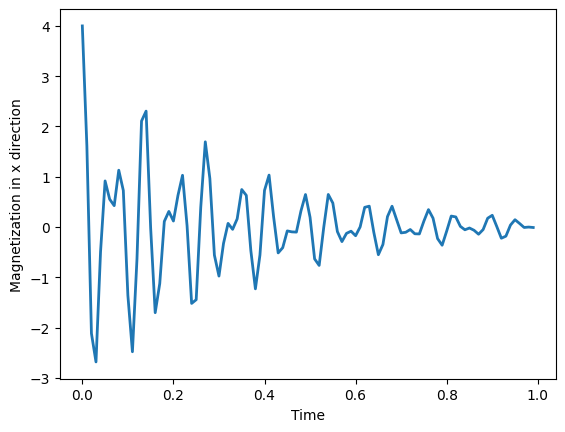

In [13]:
plt.figure(dpi=100)
plt.plot(times, c_xx, color="C0", lw=2.0)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Magnetization in x direction", fontsize=10)
plt.show()

## 5. Finding the Spectrum

We obtain the spectrum from the correlation functions via a Fourier transform (see also arXiv:2404.18903 for derivations). With a rotating‑frame offset $\bar\omega$ and an effective linewidth parameter $\Gamma$, the spectrum is
$$
S(\omega)
=\,\mathrm{Re}\!\int_{0}^{\infty} dt\; e^{-i(\omega-\bar\omega)t - \Gamma t}\,
\mathrm{Tr} \left( \hat I_x^{\rm tot}(t)\,\hat I_x^{\rm tot}(0) \right)
-\,\mathrm{Im}\!\int_{0}^{\infty} dt\; e^{-i(\omega-\bar\omega)t - \Gamma t}\,
\mathrm{Tr} \left( \hat I_y^{\rm tot}(t)\,\hat I_x^{\rm tot}(0) \right).
$$
We implement this numerically with a causal FFT routine and the rotating‑frame frequency correction. 

In [14]:
# Larmor/reference frequency in Hz at the given field.
reference_energy_hz = GYROMAGNETIC_RATIOS[isotope_1H] * field_T / (2 * np.pi)

# Conversion factor to go from Hz to ppm at this field: ppm = (Hz) * (1e6 / v0)
Hz_to_ppm_conversion = 1e6 / reference_energy_hz

In [15]:
spectrum_full, ppm = time_signal_to_spectrum(
    c_xx,
    c_yx,
    trotter_timestep,
    number_of_trottersteps,
    Hz_to_ppm_conversion=Hz_to_ppm_conversion,
    chem_shift_hz=chemical_shift_hz,
)

We now load a reference spectrum computed via exact diagonalization using HQS Spectrum Tools (for comparison). You can also compute such spectra directly with HQS Spectrum Tools for arbitrary systems.

In [16]:
solver_settings = hqs_nmr.NMRSolverSettings(solve_exactly=True)
calculation_parameters = hqs_nmr.NMRCalculationParameters(
    field_T=field_T,
    fwhm_Hz=1.0,
    solver_settings=solver_settings,
)
result_spectrum_exact = hqs_nmr.calculate.calculate_spectrum(
    molecule_parameters=parameters, calculation_parameters=calculation_parameters
)

hqs_spectrum_tools_ppm = result_spectrum_exact.spectrum.omegas_ppm
hqs_spectrum_tools_spectrum = np.sum(result_spectrum_exact.spectrum.spin_contributions, axis=0)
hqs_spectrum_tools_spectrum /= np.max(hqs_spectrum_tools_spectrum)

We compare the simulated spectrum to the exact result from HQS Spectrum Tools.

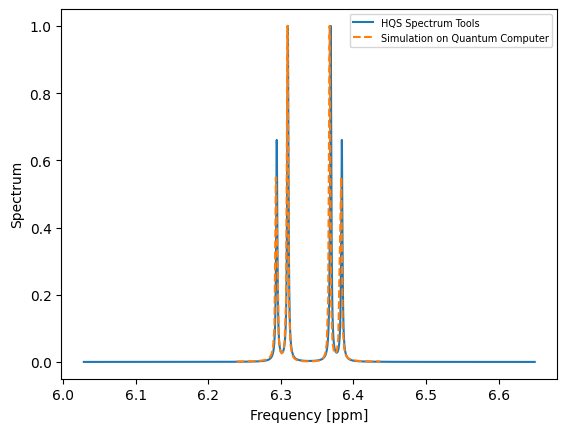

In [17]:
plt.figure(dpi=100)
plt.plot(
    hqs_spectrum_tools_ppm, hqs_spectrum_tools_spectrum, color="C0", label="HQS Spectrum Tools"
)
plt.plot(ppm, spectrum_full, color="C1", ls="--", label="Simulation on Quantum Computer")

plt.xlabel("Frequency [ppm]")
plt.ylabel("Spectrum")
plt.legend(fontsize=7)
plt.show()

In [18]:
rmse = spectrum_rmse(hqs_spectrum_tools_spectrum, hqs_spectrum_tools_ppm, spectrum_full, ppm)

print("RMSE:", rmse)
print("RMSE scaled with number spins:", rmse / number_spins**2)

RMSE: 0.09256411088982489
RMSE scaled with number spins: 0.02314102772245622
